In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import textwrap
from scipy.stats import entropy

In [2]:
# Load the data
df_pbs = pd.read_csv('../pbs_c/cmake-build-debug/pbsBlocks.csv')
df_cmp = pd.read_csv('../pbs_c/cmake-build-debug/comparison.csv')

In [3]:
df_pbs.describe()

,Block Number,Proposer ID,Builder ID,Winning Bid Value,Winning Block Value,Reward,Builder ID 1 Bid,Builder ID 2 Bid,Builder ID 3 Bid,Builder ID 4 Bid,...,Builder ID 1 Block Value,Builder ID 2 Block Value,Builder ID 3 Block Value,Builder ID 4 Block Value,Builder ID 5 Block Value,Builder ID 10 Block Value,Builder ID 30 Block Value,Builder ID 50 Block Value,Builder ID 70 Block Value,Builder ID 90 Block Value
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,25000.500000,26.413120,30.750760,467.630086,486.573523,416.722428,209.974156,208.183990,211.895740,211.424620,...,407.309676,403.981003,410.562675,410.512653,408.245035,502.246028,505.298919,506.329049,509.728880,509.914908
std,14433.901067,30.829627,31.849916,153.423164,136.831010,206.389755,98.520419,99.378814,97.806609,97.898797,...,170.253728,171.712979,168.566702,169.064330,169.087480,158.327900,155.993230,155.590241,153.342026,152.828554
min,1.000000,1.000000,1.000000,29.500000,32.540900,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.096392,0.080154,0.236224,0.053409,0.198260
25%,12500.750000,3.000000,4.000000,357.839750,394.567250,294.198000,135.500000,132.000000,138.500000,138.000000,...,301.221000,295.278750,306.285000,306.955500,304.203000,420.429250,424.454250,425.698250,430.453250,430.594500
50%,25000.500000,5.000000,10.000000,474.178500,486.150000,453.675500,222.000000,220.000000,224.000000,224.000000,...,416.303000,413.895500,418.727500,418.802500,416.646500,520.685000,522.821000,523.785500,526.079000,526.229000
75%,37500.250000,50.000000,50.000000,575.677250,578.193000,564.457750,293.500000,292.500000,294.500000,294.000000,...,520.954500,518.319750,522.506000,522.535750,520.343500,607.522500,608.340250,609.160000,610.381000,610.248750
max,50000.000000,90.000000,90.000000,981.330000,1038.420000,948.893000,650.500000,833.000000,651.000000,650.000000,...,951.652000,951.652000,951.652000,951.652000,951.652000,1038.420000,1038.420000,1038.420000,1038.420000,1038.420000


In [4]:
def get_builder_type(id):
    if 1 <= id <= 9:
        return 'Normal Proposer Builder'
    elif 10 <= id <= 999:
        return 'MEV Proposer Builder'
    else:
        return 'Unknown Builder'

def adjust_builder_id(id):
    if(get_builder_type(id) == 'MEV Proposer Builder'):
        return int(int(id) / 20 + 1)
    else:
        return id

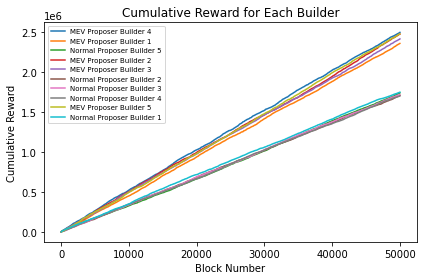

In [5]:
builder_ids = df_pbs['Builder ID'].unique()
fig, axs = plt.subplots()
for builder_id in builder_ids:
    builder_df_pbs = df_pbs[df_pbs['Builder ID'] == builder_id]
    cumulative_rewards = np.cumsum([reward for reward, id in zip(df_pbs['Reward'], df_pbs['Builder ID']) if id == builder_id])
    axs.plot(builder_df_pbs['Block Number'].values, cumulative_rewards, label=f'{get_builder_type(builder_id)} {adjust_builder_id(builder_id)}')

axs.set_title('Cumulative Reward for Each Builder')
axs.set_xlabel('Block Number')
axs.set_ylabel('Cumulative Reward')
axs.legend(loc='best',prop={'size': 7})
plt.tight_layout()
plt.show()

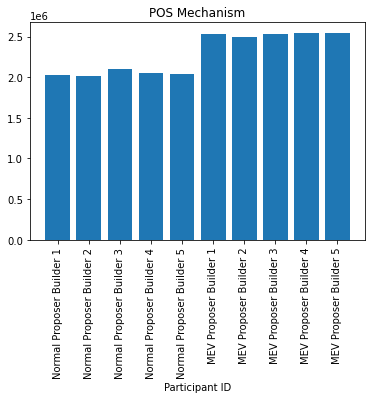

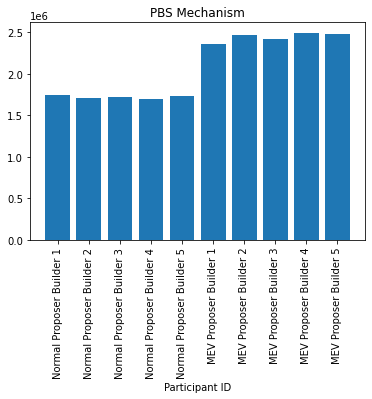

In [6]:
total_rewards_pos = []
total_rewards_pbs = []
builder_ids = np.sort(df_pbs['Builder ID'].unique())

for builder_id in builder_ids:
    cumulative_rewards_pbs = ([reward for reward, id in zip(df_pbs['Reward'], df_pbs['Builder ID']) if id == builder_id])
    total_rewards_pbs.append(sum(cumulative_rewards_pbs))

    cumulative_rewards_pos = [reward for reward, id in zip(df_cmp['POS Block Value'], df_cmp['POS Builder ID']) if id == builder_id]
    total_rewards_pos.append(sum(cumulative_rewards_pos))


builder_ids = [f'{get_builder_type(builder_id)} {adjust_builder_id(builder_id)}' for builder_id in builder_ids]
plt.bar(builder_ids, total_rewards_pos)
plt.title('POS Mechanism')
plt.xlabel('Participant ID')
plt.xticks(rotation=90) 
plt.show()

plt.bar(builder_ids, total_rewards_pbs)
plt.title('PBS Mechanism')
plt.xlabel('Participant ID')
plt.xticks(rotation=90) 
plt.show()



In [7]:
def gini(x):
    """Compute Gini coefficient of array of values"""
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    return diffsum / (len(x)**2 * np.mean(x))

In [8]:
gini_pbs = gini(np.array(total_rewards_pbs))
gini_pos = gini(np.array(total_rewards_pos))

print(f'Gini coefficient for PBS rewards: {gini_pbs}')
print(f'Gini coefficient for POS rewards: {gini_pos}')

Gini coefficient for PBS rewards: 0.0912048852517052
Gini coefficient for POS rewards: 0.05556773412239055


In [9]:
# Herfindahl-Hirschman Index (HHI) 
def hhi(x):
    """Compute Herfindahl-Hirschman Index of array of values"""
    return (x**2).sum() / (x.sum())**2

hhi_pos = hhi(np.array(total_rewards_pos))
hhi_pbs = hhi(np.array(total_rewards_pbs))

print(f"HHI for PBS: {hhi_pbs}")
print(f"HHI for POS: {hhi_pos}")

HHI for PBS: 0.10304139451511475
HHI for POS: 0.10112002189780653
